In [1]:
!pip install numpy==1.26.4 --quiet

In [2]:
# Install the Surprise library (only needed once in Colab)
!pip install scikit-surprise

# Import necessary libraries
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load built-in MovieLens 100k dataset
data = Dataset.load_builtin('ml-100k')

# Split into training and test sets (80/20 split)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [4]:
# Initialize SVD model (Singular Value Decomposition)
model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)

# Train the model on training data
model.fit(trainset)

In [5]:
# Generate predictions on the test set
predictions = model.test(testset)

# Calculate and print RMSE and MAE
print("Evaluation Metrics on Test Set:")
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Evaluation Metrics on Test Set:
RMSE: 0.9350
MAE:  0.7367


In [9]:
# 1) Download & unzip the official MovieLens 100K archive (if not already present)
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

# 2) Load ratings from the extracted folder
ratings_df = pd.read_csv(
    'ml-100k/u.data',
    sep='\t',
    names=['user_id','item_id','rating','timestamp'],
    engine='python'
)

# 3) Load movie titles
movies_df = pd.read_csv(
    'ml-100k/u.item',
    sep='|',
    encoding='latin-1',
    header=None,
    names=[
        'item_id','title','release_date','video_release','IMDb_URL',
        'unknown','Action','Adventure','Animation','Children','Comedy','Crime',
        'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
        'Romance','Sci-Fi','Thriller','War','Western'
    ],
    usecols=['item_id','title'],
    engine='python'
)

# 4) Choose a user for recommendations
user_id = '10'  # string for Surprise.predict()

# 5) Find all movie IDs, then those the user hasn't rated
all_movie_ids = ratings_df['item_id'].unique()
rated = ratings_df[ratings_df['user_id']==int(user_id)]['item_id']
unrated = [mid for mid in all_movie_ids if mid not in rated.values]

# 6) Predict ratings for all unrated movies
preds = [(mid, model.predict(user_id, str(mid)).est) for mid in unrated]

# 7) Sort by predicted score descending
preds.sort(key=lambda x: x[1], reverse=True)

# 8) Take top‑10 and merge titles
top_n = preds[:10]
top_n_df = pd.DataFrame(top_n, columns=['item_id','predicted_rating'])
top_n_df = top_n_df.merge(movies_df, on='item_id')[['title','predicted_rating']]

# 9) Display recommendations
print(f"\nTop 10 movie recommendations for User {user_id}:\n")
print(top_n_df.to_string(index=False))

--2025-07-12 15:39:06--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.39MB/s    in 0.9s    

2025-07-12 15:39:07 (5.39 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

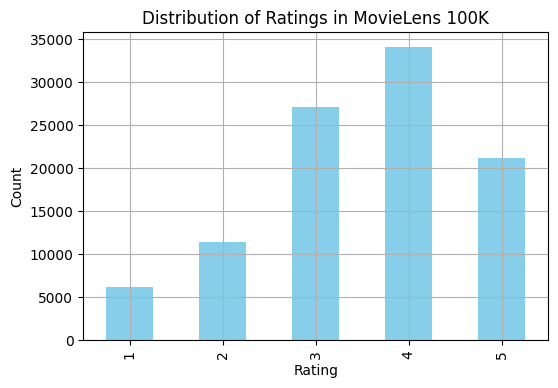

In [10]:
# 📊 Cell 6: Plot rating distribution in the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
ratings_df['rating'] \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar', color='skyblue')

plt.title("Distribution of Ratings in MovieLens 100K")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()